In [1]:
from collections import namedtuple
from typing import Optional
from toml import load
from copy import deepcopy
from uuid import uuid4
from xml.etree import ElementTree
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [5]:
class PositionBase:
    pass


class PositionWithAutoFocus(PositionBase):

    def __init__(self, x=None, y=None, z=None, autofocus_offset=None, label=None):
        self.label = label
        self.x = x
        self.y = y
        self.z = z
        self.autofocus_offset = autofocus_offset

    def get_xy(self):
        if not ((self.x is None) or (self.y is None)):
            return [self.x, self.y]

        return None

    def get_z(self):
        return self.z

    def get_autofocus_offset(self):
        return self.autofocus_offset

    def as_dict(self):
        return {
            "label": self.label,
            "x": self.x,
            "y": self.y,
            "z": self.z,
            "autofocus_offset": self.autofocus_offset
        }


In [6]:
def positions_from_xml(fp):

    tree = ElementTree.parse(fp)
    root = tree.getroot()

    positions = []

    for node in root[0]:
        if node.attrib["runtype"] != "NDSetupMultipointListItem":
            continue

        nv = {n.tag: n.attrib["value"] for n in node if n.attrib.get("value", None) is not None}

        for tag in ["dXPosition", "dYPosition", "dZPosition", "dPFSOffset"]:
            val = nv.get(tag)
            if val is not None:
                val = float(val)

            nv[tag] = val

        if (nv["dPFSOffset"] is not None) and (nv["dPFSOffset"] < 0):
            nv["dPFSOffset"] = None

        positions.append(PositionWithAutoFocus(
            x=nv["dXPosition"],
            y=nv["dYPosition"],
            z=nv["dZPosition"],
            autofocus_offset=nv["dPFSOffset"],
            label=nv["strName"]
        ))

    return positions

In [ ]:
f

[[41283.3 42492.  33057.7 32174.5 24447.9 23874.2 15640.8 14358.3 12772.4
  22314.1 24057.3 31608.9 33387.4 31791.9 41854.6 40174.6]
 [15752.4 14679.5 14053.1 15240.3 15214.2 14127.3 23725.9 24737.5 23145.5
  24469.6 24291.3 24601.7 24089.5 23409.2 24013.5 24043.8]]
[-0.0058453  -0.00592309]


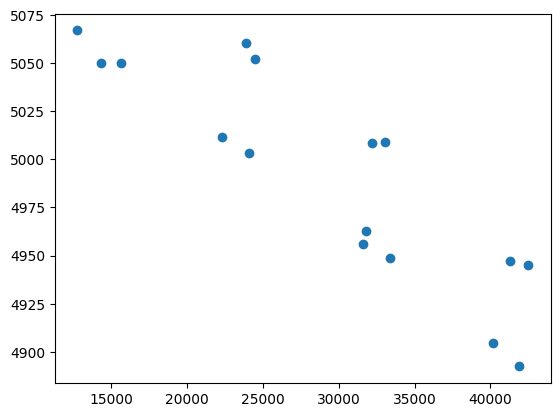

In [19]:
from sklearn.linear_model import LinearRegression

xml = r"E:\Harrison\cells\barbounce1\multipoints.xml"
positions = positions_from_xml(xml)

x = [p.x for p in positions]
y = [p.y for p in positions]
z = [p.z for p in positions]

model = LinearRegression()
X = np.stack([x, y], 0)
print(X)
res = model.fit(X.T, z)

print(model.coef_)

plt.scatter(x, z)